In [168]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import math
from typing import Counter
import copy
import random
import matplotlib.pyplot as plt 


data = np.load("C:\\Users\\baljyot\\Downloads\\mnist.npz")
x_train=data['x_train']
y_train=data['y_train']
x_test=data['x_test']
y_test=data['y_test']

indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]

val_indices_0 = indices_0[:1000]
val_indices_1 = indices_1[:1000]

train_indices_0 = indices_0[1000:]
train_indices_1 = indices_1[1000:]

total_1=len(train_indices_1)
total_n1=len(train_indices_0)

train_indices = np.concatenate([train_indices_0, train_indices_1])

val_indices = np.concatenate([val_indices_0, val_indices_1])

np.random.shuffle(train_indices)


x_val = np.array(x_train[val_indices])
y_val = np.array(y_train[val_indices])
x_train = np.array(x_train[train_indices])
y_train = np.array(y_train[train_indices])

indices = np.where((y_test == 0) | (y_test == 1))[0]
x_test =np.array(x_test[indices])
y_test = np.array(y_test[indices])


flattened=[]
for i in range(len(x_train)):
    flattened.append(x_train[i].flatten())
x_train=np.array(flattened)
flattened=[]
for i in range(len(x_val)):
    flattened.append(x_val[i].flatten())
x_val=np.array(flattened)
flattened=[]
for i in range(len(x_test)):
    flattened.append(x_test[i].flatten())
x_test=np.array(flattened)


x_train=np.transpose(x_train)
sums=[]
centralisedMean=np.mean(x_train,axis=1)
centralisedData=[]
for i in range(x_train.shape[0]):
    l=[]
    for j in range(x_train.shape[1]):
        l.append(x_train[i][j]- centralisedMean[i])
    centralisedData.append(l)
centralisedMean=np.array(np.mean(centralisedData,axis=1))

S=np.matmul( centralisedData ,np.transpose(centralisedData))/x_train.shape[1]

eigenvalues, eigenvectors = np.linalg.eigh(S)
eigenvalues = eigenvalues[::-1]
U = np.flip(eigenvectors, axis=1)

nUp=U[:,:5]

x_proj=np.matmul(nUp.T,x_train-x_train.mean(axis=1)[:,np.newaxis])

x_test=np.transpose(x_test)
x_proj_test=np.matmul(nUp.T,x_test-x_train.mean(axis=1)[:,np.newaxis])

x_val=np.transpose(x_val)
x_val_proj=np.matmul(nUp.T,x_val-x_train.mean(axis=1)[:,np.newaxis])


x_val=x_val_proj
x_test=x_proj_test
x_train=x_proj


y_train = np.array(y_train).astype(np.int8)
y_val = np.array(y_val).astype(np.int8)
y_test = np.array(y_test).astype(np.int8)

y_train[y_train == 0] = -1
y_val[y_val == 0] = -1
y_test[y_test == 0] = -1



In [169]:
class Region:
   def __init__(self):
      self.one=0
      self.n_one=0
      self.total_frequency=0
      self.mean=0
   def make_region_predict(self,one,n_one):
      self.one=one
      self.n_one=n_one
      self.total_frequency=one+n_one

      self.mean=(self.one-self.n_one)/self.total_frequency

   def calc_ssr(self):
      return (self.total_frequency-(((self.one-self.n_one)**2)/self.total_frequency))
   
   def add(self,val , index, y_train):
      if y_train[index]==-1:
         self.n_one+=1
      else:
         self.one+=1
      self.total_frequency+=1
      self.mean=(self.one-self.n_one)/self.total_frequency


   def remove(self,val,index,y_train):
      if y_train[index]==-1:
         self.n_one-=1
      else:
         self.one-=1
      self.total_frequency-=1
      self.mean=(self.one-self.n_one)/self.total_frequency
   def print_info(self):
      print("one ",self.one,end="  ")
      print("n_one ",self.n_one,end="  ")
      print("prediction ", self.mean,end="  ")

      # print("misclassified ",self.misclassified_weight,end="  ")
      print("tot freq ",self.total_frequency,end=" ")
      print("ssr " ,(self.total_frequency-(((self.one-self.n_one)**2)/self.total_frequency)))

class Tree:
    def __init__(self,left,right,cut,dim):
        self.Left=left 
        self.Right=right 
        self.cut=cut 
        self.dim=dim 
    def predict(self,val):
        if (val<=self.cut):
            return self.Left.mean
        else: 
            return self.Right.mean
        
      
      

In [170]:

#total_1 ,totalt_n1 will change need to take of this
values=[]
num_decesion_tree=300
stumps=[]
minimumm=1000
maximum_accuracy=-1
max_num_tree=0
residuals=copy.deepcopy(list(y_train))
pred_on_val=[0]*y_val.shape[0]
minimum_mse=100
min_mse_num_tree=-1
trees=[]
mse_plot=[]
for st in range(num_decesion_tree):
    mini_ssr=-1
    best_cut=None   
    best_left=None
    best_right=None
    best_dimension=None

    for itr in range(5):
        #all the values are unique so no need to do np.unique() (maybe beacuse of PCA)
        curr=x_train[itr]
        sorted_indices = np.argsort(curr)
        s_vals =curr[sorted_indices]
        s_y_train = y_train[sorted_indices]

        cut1=(s_vals[0]+s_vals[1])/2
        i_fr_1,i_fr_n1,j_fr_1,j_fr_n1=0,0,0,0
        i_fr=np.where(s_vals==s_vals[0])[0]
        if (s_y_train[0]==1): i_fr_1=1
        else: i_fr_n1=1
        Left=Region()
        Left.make_region_predict(i_fr_1,i_fr_n1)
        
        j_fr_1=total_1-i_fr_1
        j_fr_n1=total_n1-i_fr_n1
        Right=Region()
        Right.make_region_predict(j_fr_1, j_fr_n1)

        new_ssr=Left.calc_ssr()+Right.calc_ssr()

        if (new_ssr<=mini_ssr or mini_ssr==-1):
            mini_ssr=new_ssr
            best_cut=cut1   
            best_left=copy.deepcopy(Left)
            best_right=copy.deepcopy(Right)
            best_dimension=itr
    
        for j in range(1,len(s_vals)-1):
            cut=(s_vals[j]+s_vals[j+1])/2

            Right.remove(s_vals[j],sorted_indices[j] , y_train)
            Left.add(s_vals[j], sorted_indices[j] , y_train)
            new_ssr=Left.calc_ssr()+Right.calc_ssr()

            
            # print("new ssr ", new_ssr," cut ",cut, " dim ",itr)
            # Left.print_info()
            # Right.print_info()
            

            if (new_ssr<=mini_ssr or mini_ssr==-1):
                mini_ssr=new_ssr
                best_cut=cut
                best_left=copy.deepcopy(Left)
                best_right=copy.deepcopy(Right)
                best_dimension=itr
   
    # print("trees ",st+1)
    # print("mini ssr ",mini_ssr,"best cut ",best_cut, "best dim ",best_dimension)
    # best_left.print_info()
    # best_right.print_info()

    best_tree=Tree(best_left,best_right,best_cut,best_dimension)
    total_1=0
    total_n1=0
    trees.append(best_tree)
    for l in range(y_train.shape[0]):
        # print(residuals[l],end=" ")
        residuals[l]=residuals[l]-((0.01)*(best_tree.predict(x_train[best_dimension][l])))
        
        if (residuals[l]<0):
            y_train[l]=-1
            total_n1+=1
        else:
            y_train[l]=1
            total_1+=1
    
    new_mse=0
    # print(new_mse)
    for o in range((y_val.shape[0])):
        pred_on_val[o] =pred_on_val[o]+ 0.01 * best_tree.predict(x_val[best_dimension][o])
        # print(x)
        new_mse=new_mse+(pred_on_val[o]- y_val[o])**2

    new_mse=new_mse/y_val.shape[0]
    if (new_mse<=minimum_mse):
        minimum_mse=new_mse
        min_mse_num_tree=st+1


    print("new mse ", new_mse,"at the ", st+1,"th stump")
    mse_plot.append(new_mse)
print("Minimum MSE ",minimum_mse )
print("Number of Tree for minimum MSE ",min_mse_num_tree )



new mse  0.9804435551652176 at the  1 th stump
new mse  0.9610833899314902 at the  2 th stump
new mse  0.9419195042985942 at the  3 th stump
new mse  0.9229518982666453 at the  4 th stump
new mse  0.9041805718356574 at the  5 th stump
new mse  0.8856055250055865 at the  6 th stump
new mse  0.8672267577764128 at the  7 th stump
new mse  0.8490442701482528 at the  8 th stump
new mse  0.8310580621210383 at the  9 th stump
new mse  0.8132681336946734 at the  10 th stump
new mse  0.7956744848692922 at the  11 th stump
new mse  0.7782771156449023 at the  12 th stump
new mse  0.761076026021373 at the  13 th stump
new mse  0.7440712159988107 at the  14 th stump
new mse  0.7272626855771793 at the  15 th stump
new mse  0.7106504347564431 at the  16 th stump
new mse  0.6942344635367051 at the  17 th stump
new mse  0.6780147719178864 at the  18 th stump
new mse  0.6619913598999813 at the  19 th stump
new mse  0.6461642274830274 at the  20 th stump
new mse  0.6305333746670283 at the  21 th stump
ne

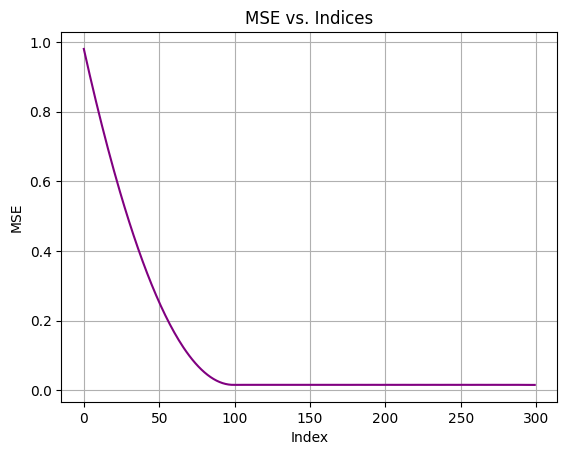

In [171]:

indices = np.arange(len(mse_plot))
plt.plot(indices, mse_plot, color='purple')
plt.xlabel('Index')
plt.ylabel('MSE')
plt.title('MSE vs. Indices')
plt.grid(True)
plt.show()

In [172]:
mset=0
for i in range(y_test.shape[0]):
    predict=0
    for j in range(min_mse_num_tree):
        predict=predict+0.01* trees[j].predict(x_test[trees[j].dim][i])
    mset=mset+(predict- y_test[i])**2

mset=mset/y_test.shape[0]
print("MSE of Test set is ",mset)
    


MSE of Test set is  0.015011203546894862


In [173]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import math
from typing import Counter
import copy
import random
import matplotlib.pyplot as plt 


data = np.load("C:\\Users\\baljyot\\Downloads\\mnist.npz")
x_train=data['x_train']
y_train=data['y_train']
x_test=data['x_test']
y_test=data['y_test']

indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]

val_indices_0 = indices_0[:1000]
val_indices_1 = indices_1[:1000]

train_indices_0 = indices_0[1000:]
train_indices_1 = indices_1[1000:]

total_1=len(train_indices_1)
total_n1=len(train_indices_0)

train_indices = np.concatenate([train_indices_0, train_indices_1])

val_indices = np.concatenate([val_indices_0, val_indices_1])

np.random.shuffle(train_indices)


x_val = np.array(x_train[val_indices])
y_val = np.array(y_train[val_indices])
x_train = np.array(x_train[train_indices])
y_train = np.array(y_train[train_indices])

indices = np.where((y_test == 0) | (y_test == 1))[0]
x_test =np.array(x_test[indices])
y_test = np.array(y_test[indices])


flattened=[]
for i in range(len(x_train)):
    flattened.append(x_train[i].flatten())
x_train=np.array(flattened)
flattened=[]
for i in range(len(x_val)):
    flattened.append(x_val[i].flatten())
x_val=np.array(flattened)
flattened=[]
for i in range(len(x_test)):
    flattened.append(x_test[i].flatten())
x_test=np.array(flattened)


x_train=np.transpose(x_train)
sums=[]
centralisedMean=np.mean(x_train,axis=1)
centralisedData=[]
for i in range(x_train.shape[0]):
    l=[]
    for j in range(x_train.shape[1]):
        l.append(x_train[i][j]- centralisedMean[i])
    centralisedData.append(l)
centralisedMean=np.array(np.mean(centralisedData,axis=1))

S=np.matmul( centralisedData ,np.transpose(centralisedData))/x_train.shape[1]

eigenvalues, eigenvectors = np.linalg.eigh(S)
eigenvalues = eigenvalues[::-1]
U = np.flip(eigenvectors, axis=1)

nUp=U[:,:5]

x_proj=np.matmul(nUp.T,x_train-x_train.mean(axis=1)[:,np.newaxis])

x_test=np.transpose(x_test)
x_proj_test=np.matmul(nUp.T,x_test-x_train.mean(axis=1)[:,np.newaxis])

x_val=np.transpose(x_val)
x_val_proj=np.matmul(nUp.T,x_val-x_train.mean(axis=1)[:,np.newaxis])


x_val=x_val_proj
x_test=x_proj_test
x_train=x_proj


y_train = np.array(y_train).astype(np.int8)
y_val = np.array(y_val).astype(np.int8)
y_test = np.array(y_test).astype(np.int8)

y_train[y_train == 0] = -1
y_val[y_val == 0] = -1
y_test[y_test == 0] = -1


#total_1 ,totalt_n1 will change need to take of this
values=[]
num_decesion_tree=1
stumps=[]
minimumm=1000
maximum_accuracy=-1
max_num_tree=0
residuals=copy.deepcopy(list(y_train))
pred_on_val=[0]*y_val.shape[0]
minimum_mse=100
min_mse_num_tree=-1
trees=[]
mse_plot=[]
for st in range(num_decesion_tree):
    mini_ssr=-1
    best_cut=None   
    best_left=None
    best_right=None
    best_dimension=None

    for itr in range(5):
        #all the values are unique so no need to do np.unique() (maybe beacuse of PCA)
        curr=x_train[itr]
        sorted_indices = np.argsort(curr)
        s_vals =curr[sorted_indices]
        s_y_train = y_train[sorted_indices]

        cut1=(s_vals[0]+s_vals[1])/2
        i_fr_1,i_fr_n1,j_fr_1,j_fr_n1=0,0,0,0
        i_fr=np.where(s_vals==s_vals[0])[0]
        if (s_y_train[0]==1): i_fr_1=1
        else: i_fr_n1=1
        Left=Region()
        Left.make_region_predict(i_fr_1,i_fr_n1)
        
        j_fr_1=total_1-i_fr_1
        j_fr_n1=total_n1-i_fr_n1
        Right=Region()
        Right.make_region_predict(j_fr_1, j_fr_n1)

        new_ssr=Left.calc_ssr()+Right.calc_ssr()

        if (new_ssr<=mini_ssr or mini_ssr==-1):
            mini_ssr=new_ssr
            best_cut=cut1   
            best_left=copy.deepcopy(Left)
            best_right=copy.deepcopy(Right)
            best_dimension=itr
    
        for j in range(1,len(s_vals)-1):
            cut=(s_vals[j]+s_vals[j+1])/2

            Right.remove(s_vals[j],sorted_indices[j] , y_train)
            Left.add(s_vals[j], sorted_indices[j] , y_train)
            new_ssr=Left.calc_ssr()+Right.calc_ssr()

            
            # print("new ssr ", new_ssr," cut ",cut, " dim ",itr)
            # Left.print_info()
            # Right.print_info()
            

            if (new_ssr<=mini_ssr or mini_ssr==-1):
                mini_ssr=new_ssr
                best_cut=cut
                best_left=copy.deepcopy(Left)
                best_right=copy.deepcopy(Right)
                best_dimension=itr
   
    # print("trees ",st+1)
    # print("mini ssr ",mini_ssr,"best cut ",best_cut, "best dim ",best_dimension)
    # best_left.print_info()
    # best_right.print_info()

    best_tree=Tree(best_left,best_right,best_cut,best_dimension)
    total_1=0
    total_n1=0
    trees.append(best_tree)
    for l in range(y_train.shape[0]):
        # print(residuals[l],end=" ")
        residuals[l]=residuals[l]-((0.01)*(best_tree.predict(x_train[best_dimension][l])))
        
        if (residuals[l]<0):
            y_train[l]=-1
            total_n1+=1
        else:
            y_train[l]=1
            total_1+=1
    
    new_mse=0
    # print(new_mse)
    for o in range((y_val.shape[0])):
        pred_on_val[o] =pred_on_val[o]+ 0.01 * best_tree.predict(x_val[best_dimension][o])
        # print(x)
        new_mse=new_mse+(pred_on_val[o]- y_val[o])**2

    new_mse=new_mse/y_val.shape[0]
    if (new_mse<=minimum_mse):
        minimum_mse=new_mse
        min_mse_num_tree=st+1


    # print("new mse ", new_mse)
    mse_plot.append(new_mse)
print("Minimum MSE ",minimum_mse )
print("Number of Tree for minimum MSE ",min_mse_num_tree )


Minimum MSE  0.9804435551652176
Number of Tree for minimum MSE  1
